Import required libraries

In [1]:
import glob
import os
import uuid

from IPython.display import Audio
import librosa
import numpy as np
import pandas as pd
import torch
import transformers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\khanh\anaconda3\envs\MusicHonours\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRAIN_DIR = "IRMAS-TrainingData\\IRMAS-TrainingData"
BATCH_SIZE = 2
# MODEL_NAME = "facebook/wav2vec2-base-960h"
# MODEL_NAME = "microsoft/wavlm-base-plus"
# MODEL_NAME = "facebook/wav2vec2-conformer-rel-pos-large"
MODEL_NAME = "facebook/hubert-base-ls960"
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
ITERATION = "wavlm-base-plus_bec878d0-eaf4-4938-8fce-05fc4fdc2381"
print(ITERATION)

wavlm-base-plus_bec878d0-eaf4-4938-8fce-05fc4fdc2381


Split

In [3]:
all_train_files = glob.glob(os.path.join(TRAIN_DIR, "*", "*.wav"))
path_mapping = [(os.path.dirname(p).split("\\")[-1], p) for p in all_train_files]

In [4]:
file_df = pd.DataFrame(path_mapping, columns=['class', 'file_path'])
#print(file_df['class'].value_counts())

train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Split the data into train and temp sets
train_df, temp_df = train_test_split(file_df, test_size=(1 - train_ratio), random_state=42)

# Split the temp set into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

print(test_df['class'].value_counts())

class
voi    157
pia    150
org    139
gac    138
gel    128
tru    127
vio    111
sax    106
cel     97
cla     97
flu     92
Name: count, dtype: int64


In [5]:
# create a mapping of labels
MAPPING = {class_name: i for i, class_name in enumerate(file_df['class'].unique())}
MAPPING

{'cel': 0,
 'cla': 1,
 'flu': 2,
 'gac': 3,
 'gel': 4,
 'org': 5,
 'pia': 6,
 'sax': 7,
 'tru': 8,
 'vio': 9,
 'voi': 10}

Initialise Dataset Class

In [6]:
class InstrumentDataSet(torch.utils.data.Dataset):

    def __init__(self, df, model_name, mapping=MAPPING):
        self.df = df
        self.df.reset_index(drop=True, inplace=True)
        try:
            self.processor = transformers.AutoProcessor.from_pretrained(MODEL_NAME)
        except:
            self.processor = transformers.AutoFeatureExtractor.from_pretrained(MODEL_NAME)
        self.mapping = mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        data_row = self.df.iloc[index, :]
        label, file_path = data_row['class'], data_row['file_path']

        # read the audio file
        audio_array, sr = librosa.load(file_path, mono=True, sr=44100)

        # passing through the preprocessor
        preprocessed_tensor = self.processor(audio_array, sampling_rate=16000, return_tensors="pt")

        if 'attention_mask' in preprocessed_tensor:
            data, attention_mask = preprocessed_tensor.values()
        else:
            data = list(preprocessed_tensor.values())[0]
            attention_mask = None

        # extract the number of label
        label = self.mapping[label]

        return {
            "data": data.squeeze(), # 16, 1 130000 -> 16, 130000
            "attention_mask": attention_mask.squeeze() if attention_mask is not None else torch.ones(data.shape[-1]),
            "label": label
        }

Create Testing dataset

In [7]:
test_ds =  InstrumentDataSet(test_df, model_name=MODEL_NAME)

C:\Users\khanh\anaconda3\envs\MusicHonours\Lib\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:53: FutureWarning: Loading a tokenizer inside Wav2Vec2Processor from a config that does not include a `tokenizer_class` attribute is deprecated and will be removed in v5. Please add `'tokenizer_class': 'Wav2Vec2CTCTokenizer'` attribute to either your `config.json` or `tokenizer_config.json` file to suppress this warning: 
  warnings.warn(


In [8]:
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
#Creates Dataloder

In [9]:
label2id = MAPPING
id2label = {i: class_name for i, class_name in label2id.items()}

Initialises Model Class

In [10]:
class AudioModel(torch.nn.Module):

    def __init__(
        self,
        labels,
        label2id,
        id2label,
        pretrained_model=MODEL_NAME
    ):
        super().__init__()
        self.pretrained_model_name = pretrained_model

        # creating the config
        self.config = transformers.AutoConfig.from_pretrained(
            self.pretrained_model_name,
            num_labels=len(labels),
            label2id=label2id,
            id2label=id2label
        )

        setattr(self.config, "freeze_extractor", True)
        setattr(self.config, "num_labels", len(labels))

        # initialize the model by passing the config created above
        self.model = transformers.AutoModelForAudioClassification.from_pretrained(
            self.pretrained_model_name,
            config=self.config)


    def forward(self, data, attention_mask):

        model_outputs = self.model(
            input_values=data,
            attention_mask=attention_mask
        )

        return model_outputs

Initialise Model Instance

In [11]:
model = AudioModel(MAPPING.values(), label2id, id2label, MODEL_NAME)

Some weights of WavLMForSequenceClassification were not initialized from the model checkpoint at microsoft/wavlm-base-plus and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load model with weights before it can be used for inference

In [12]:
# Load model checkpoint
checkpoint = torch.load(f"{ITERATION}_best_val_performance.pt")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Testing Script which also produces and saves Classification Report and Confusion Matrix

In [13]:
# testing

def evaluate_metrics(labels, predictions, mapping, modelname=MODEL_NAME):

    acc = accuracy_score(labels, predictions)

    f1score = f1_score(labels, predictions, average="macro")

    cm = confusion_matrix(labels, predictions)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax); #producing notebook output of confusion matrix
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
    ax.set_title(f'Confusion Matrix {modelname}');
    ax.xaxis.set_ticklabels(list(MAPPING.keys())); ax.yaxis.set_ticklabels(list(MAPPING.keys())) #[list(MAPPING.keys())[i] for i in range(-1, -len(mapping)-1, -1)]);

    plt.savefig(f"confusion_matrix_{modelname.replace('/','_')}.png") #saving image of matrix
    
    fig, ax = plt.subplots()
    clf_report = classification_report(labels,
                                   predictions,
                                   labels=np.arange(len(mapping)),
                                   target_names=list(mapping.keys()),
                                   output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
    plt.title(f"Classification Report {modelname}");

    plt.savefig(f"Classification Report_{modelname.replace('/','_')}.png") #saving image of report
    plt.show()
    
    return {
        "acc": acc,
        "f1": f1score,
        "cm": confusion_matrix,
        "clf_report": clf_report
    }


def test(model, test_dl, device):
    model.to(device)
    model.eval()

    epoch_predictions_test, epoch_labels_test = [], []

    for batch_num, batch in enumerate(test_dl):

        input_data = batch['data'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['label'].to(device)

        ################# 1. obtain predictions
        prediction = model(
            data=input_data,
            attention_mask=attention_mask
            ).logits

        # normalize predictions
        norm_predictions = torch.nn.Softmax(dim=1)(prediction)

        predicted_labels = torch.argmax(norm_predictions, dim=1)
        epoch_predictions_test.append(predicted_labels)
        epoch_labels_test.append(label)

    epoch_l = np.concatenate([p.cpu().numpy() for p in epoch_labels_test])
    epoch_p = np.concatenate([p.cpu().numpy() for p in epoch_predictions_test])

    return {
        "labels": epoch_l,
        "predictions": epoch_p
    }


In [14]:
labels_and_preds = test(model, test_dl, DEVICE)

C:\Users\khanh\anaconda3\envs\MusicHonours\Lib\site-packages\torch\nn\functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


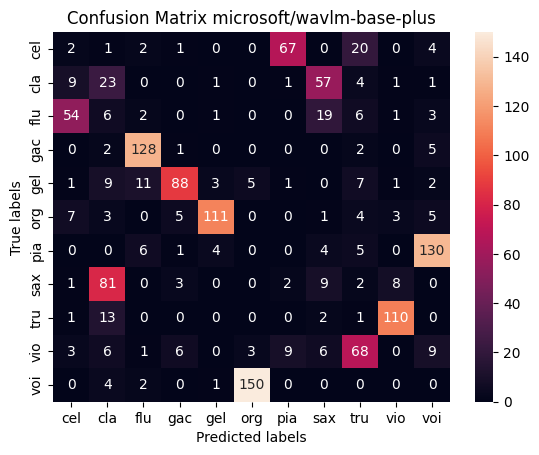

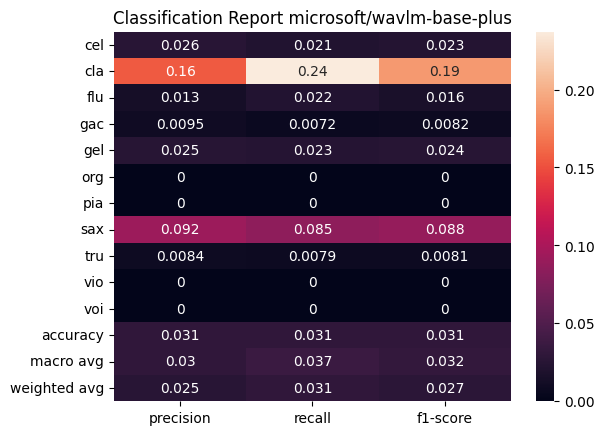

In [15]:
metrics = evaluate_metrics(labels_and_preds['labels'], labels_and_preds['predictions'], MAPPING)

In [16]:
print(metrics['f1'])
print(metrics['acc'])

0.03233617283240326
0.030551415797317436
